[1. EDA](#eda) <br>

[2. Define Model](#define)<br>

[3. Train and Evaluate](#train_evaluate)<br>

- [3.1 Train the Model](#train)<br>
- [3.2 Evaluate the Model](#evaluate)<br>
    
[4. Conclusion](#conclusion)<br> 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import re
import string
import gc

# Import Keras and Scikit-learn modules
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.python.client import device_lib

# Install and import Transformers library
!pip install transformers
from transformers import AutoTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from keras.utils import np_utils

# Download necessary NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

SEED = 10

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [2]:
# Read data from CSV file
df = pd.read_csv('/kaggle/input/final-dataset/Updated_And_Uniq_Reviews-Last.csv')
df.head(5)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,2
3,"unique, great stay, wonderful time hotel monac...",3
4,"great stay great stay, went seahawk game aweso...",3


In [3]:
# Print the count of unique values in 'Rating' column
df['Rating'].value_counts()

2    14514
1    14386
3    13772
Name: Rating, dtype: int64

In [4]:
#X is assigned the column 'Review' from the df DataFrame, which likely contains a collection of text reviews.
#y is assigned the column 'Rating' from the same df DataFrame, which likely contains the corresponding rating values for each review in X.
#These two variables will be used later on for training and testing a machine learning model.
X = df['Review']
y = df['Rating']

In [5]:
# Create a new column 'num_words' to store the number of words in each review
df['num_words'] = df['Review'].apply(lambda x: len(x.split()))

In [6]:
df.head()

,Review,Rating,num_words
0,nice hotel expensive parking got good deal sta...,2,87
1,ok nothing special charge diamond member hilto...,2,250
2,nice rooms not 4* experience hotel monaco seat...,2,217
3,"unique, great stay, wonderful time hotel monac...",3,89
4,"great stay great stay, went seahawk game aweso...",3,191


Text(0.5, 1.0, 'Distribution of Review Ratings')

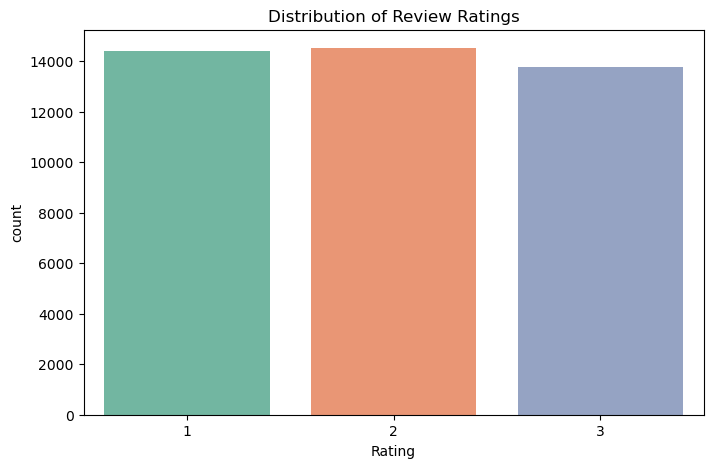

In [7]:
# Plot a histogram of the distribution of review ratings
plt.figure(figsize = (8,5))
sns.countplot(x = df['Rating'], palette = 'Set2')
plt.title('Distribution of Review Ratings')

In [8]:
# Define stop words, porter stemmer, and WordNet lemmatizer
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function to clean the text data
def clean_text(text):
    
    #Removing punctuation
    for punctuation in list(string.punctuation):
        text = text.replace(punctuation, '')
        
    #Cleaning numbers
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
#     print(type(text))
    return text

Text(0.5, 1.0, 'Distribution of the Words count')

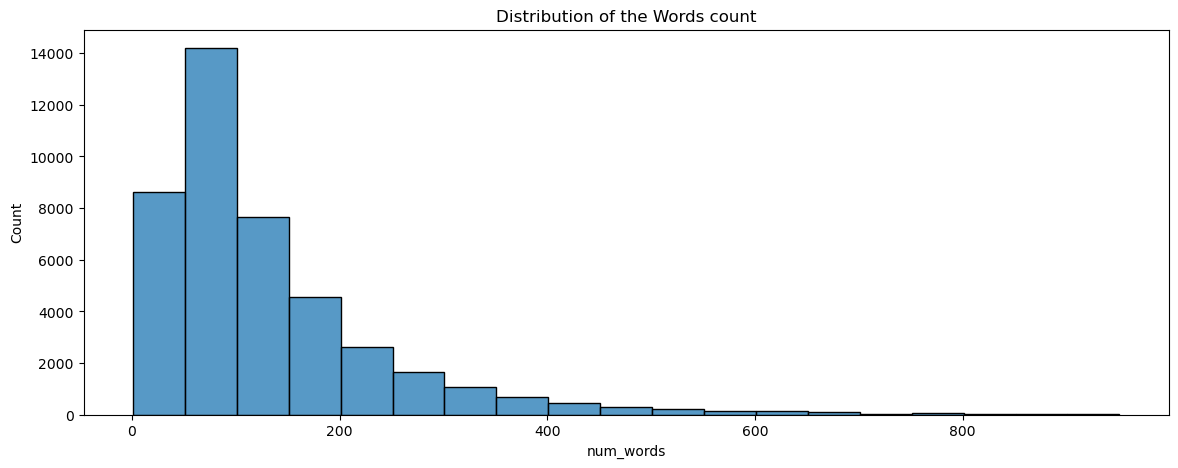

In [9]:
#define the plot for the distribution of the number of words in reviews
plt.figure(figsize = (14,5))
sns.histplot(df['num_words'], bins = range(1, 1000, 50))
plt.title('Distribution of the Words count')

In [10]:
# apply the clean_text function to the 'Review' column of the dataset and save the result as a new dataframe
def remove_contractions_df(x):
    for i in ['Review']:
        x[i] = x[i].apply(clean_text)
        return x

df_new = remove_contractions_df(df)

In [11]:
df_new.head()

,Review,Rating,num_words
0,nice hotel expensive parking got good deal sta...,2,87
1,ok nothing special charge diamond member hilto...,2,250
2,nice rooms not 4 experience hotel monaco seatt...,2,217
3,unique great stay wonderful time hotel monaco ...,3,89
4,great stay great stay went seahawk game awesom...,3,191


In [12]:
#set the maximum length of each token sequence to 200 since most words were of length <= 200
MAX_LEN = 200

#define a function to create the model
def get_model():
    dropout_rate = 0.2

    #define the input layers
    input_ids = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')
    
    #get the embeddings from the RoBERTa model and extract the pooled output
    embeddings = roberta([input_ids, input_mask])[1] #pooler output
    print(embeddings)
    
    #apply dropout
    out = Dropout(0.3)(embeddings)
    
    #add a 64 unit dense layer with relu activation and another dropout layer
    out = Dense(64, activation = 'relu')(out)
    out = Dropout(0.3)(out)

    #add the output layer with softmax activation
    y = Dense(5, activation = 'softmax')(out)
    
    #create the model with input and output layers
    model = Model(inputs=[input_ids, input_mask], outputs=y)

    #set the trainable attribute of the RoBERTa layer to True
    model.layers[2].trainable = True
    
    #define the optimizer
    optimizer = Adam(learning_rate = 1e-06, epsilon = 1e-08)
    
    #compile the model with SparseCategoricalCrossentropy loss and SparseCategoricalAccuracy metric
    model.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = [keras.metrics.SparseCategoricalAccuracy()])
    
    return model

#define a tokenization function to preprocess the input data
def get_tokens(X):
    
    #tokenize the input text using the RoBERTa tokenizer
    X = tokenizer(
                text = list(X),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = 'max_length', #pad all short sequences to max_len
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )
    
    return X

In [13]:
#initialize the tokenizer and RoBERTa model from pre-trained weights
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta = TFRobertaModel.from_pretrained("roberta-base")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_roberta_model/roberta/pooler/dense/Tanh:0', description="created by layer 'tf_roberta_model'")


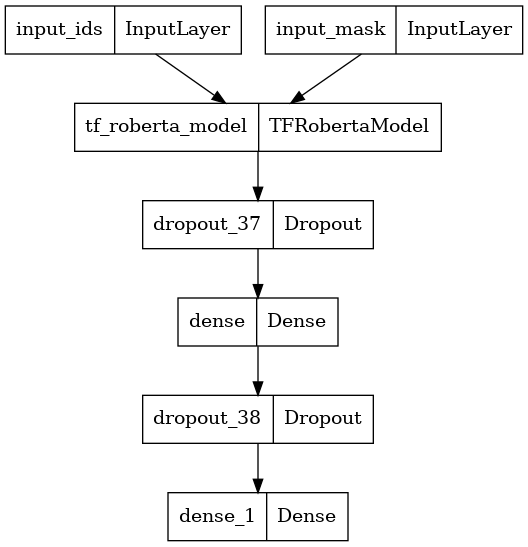

In [14]:
#create the model
model = get_model()

#plot the model architecture
tf.keras.utils.plot_model(model)

In [15]:
#split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [16]:
#preprocess the training and testing input data using the tokenization function
X_train_seq = get_tokens(X_train)
X_test_seq = get_tokens(X_test)

#train the model using the preprocessed training data and evaluate its performance on the preprocessed testing
history = model.fit(x = {'input_ids': X_train_seq['input_ids'],'input_mask': X_train_seq['attention_mask']}, 
                    y = y_train.values, 
                    epochs = 15,
                    validation_split = 0.2, 
                    batch_size = 30, 
                    callbacks = [EarlyStopping(monitor='val_sparse_categorical_accuracy',
                                               mode='max', 
                                               patience = 4, 
                                               verbose = False,
                                               restore_best_weights=True)])

Epoch 1/15
911/911 [==============================] - 1278s 1s/step - loss: 0.8337 - sparse_categorical_accuracy: 0.6264 - val_loss: 0.5295 - val_sparse_categorical_accuracy: 0.7636
Epoch 2/15
911/911 [==============================] - 1216s 1s/step - loss: 0.5723 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.4937 - val_sparse_categorical_accuracy: 0.7875
Epoch 3/15
911/911 [==============================] - 1215s 1s/step - loss: 0.5202 - sparse_categorical_accuracy: 0.7758 - val_loss: 0.4603 - val_sparse_categorical_accuracy: 0.7989
Epoch 4/15
911/911 [==============================] - 1212s 1s/step - loss: 0.4923 - sparse_categorical_accuracy: 0.7867 - val_loss: 0.4492 - val_sparse_categorical_accuracy: 0.7972
Epoch 5/15
911/911 [==============================] - 1214s 1s/step - loss: 0.4671 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.4355 - val_sparse_categorical_accuracy: 0.8033
Epoch 6/15
911/911 [==============================] - 1214s 1s/step - loss: 0.4501 - spars

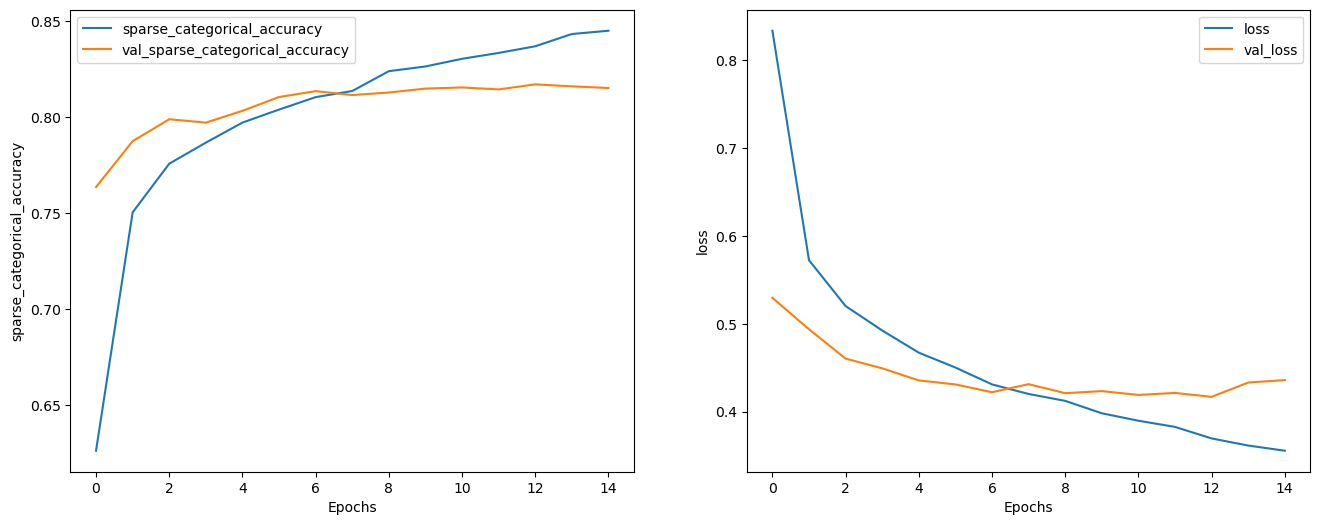

In [17]:
# Creates a figure with two subplots, one for the training and validation sparse categorical accuracy over the epochs, and another for the training and validation loss over the epochs.
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'sparse_categorical_accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [18]:
# Uses model to predict the labels for the test data, converts the predicted probabilities to the corresponding labels, and prints the classification report with precision, recall, F1-score, and support for each class.
y_pred = model.predict({'input_ids':X_test_seq['input_ids'],'input_mask':X_test_seq['attention_mask']})
y_pred = np.argmax(y_pred, axis = 1)

267/267 [==============================] - 113s 412ms/step


In [19]:
# print classification report
print(classification_report(y_test.values,y_pred))

              precision    recall  f1-score   support

           1       0.95      0.90      0.92      2877
           2       0.76      0.68      0.72      2903
           3       0.74      0.87      0.80      2755

    accuracy                           0.81      8535
   macro avg       0.82      0.82      0.81      8535
weighted avg       0.82      0.81      0.81      8535



Text(70.72222222222221, 0.5, 'Real Labels')

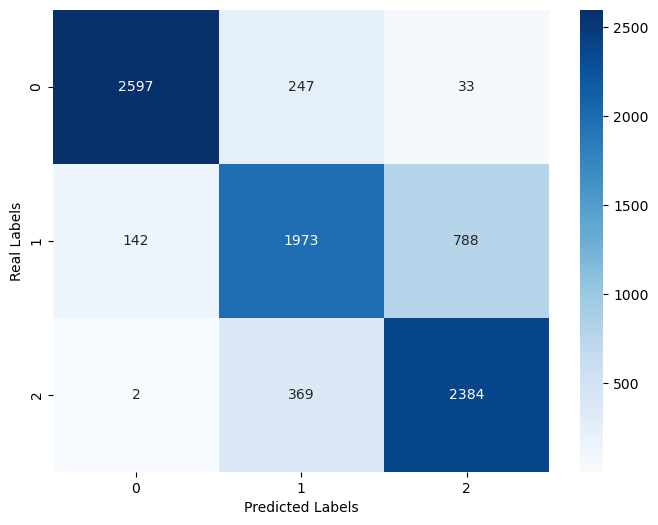

In [20]:
# plot heatmap of confusion matrix for the predicted and actual labels of the test data.
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test.values,y_pred), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')